In [1]:
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv") 

test  = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")
test_labels = test.iloc[:,0]

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED   = 42
BATCH_SIZE = 64

LABEL_MAP = {0:"T-shirt",
             1:"Trouser",
             2:"Pullover",
             3:"Dress",
             4:"Coat",
             5:"Sandal",
             6:"Shirt",
             7:"Sneaker",
             8:"Bag",
             9:"Ankle Boot"
            }
NUM_MAP = {label:num for num,label in LABEL_MAP.items()}

# Visualize Images

In [4]:
train.label.value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

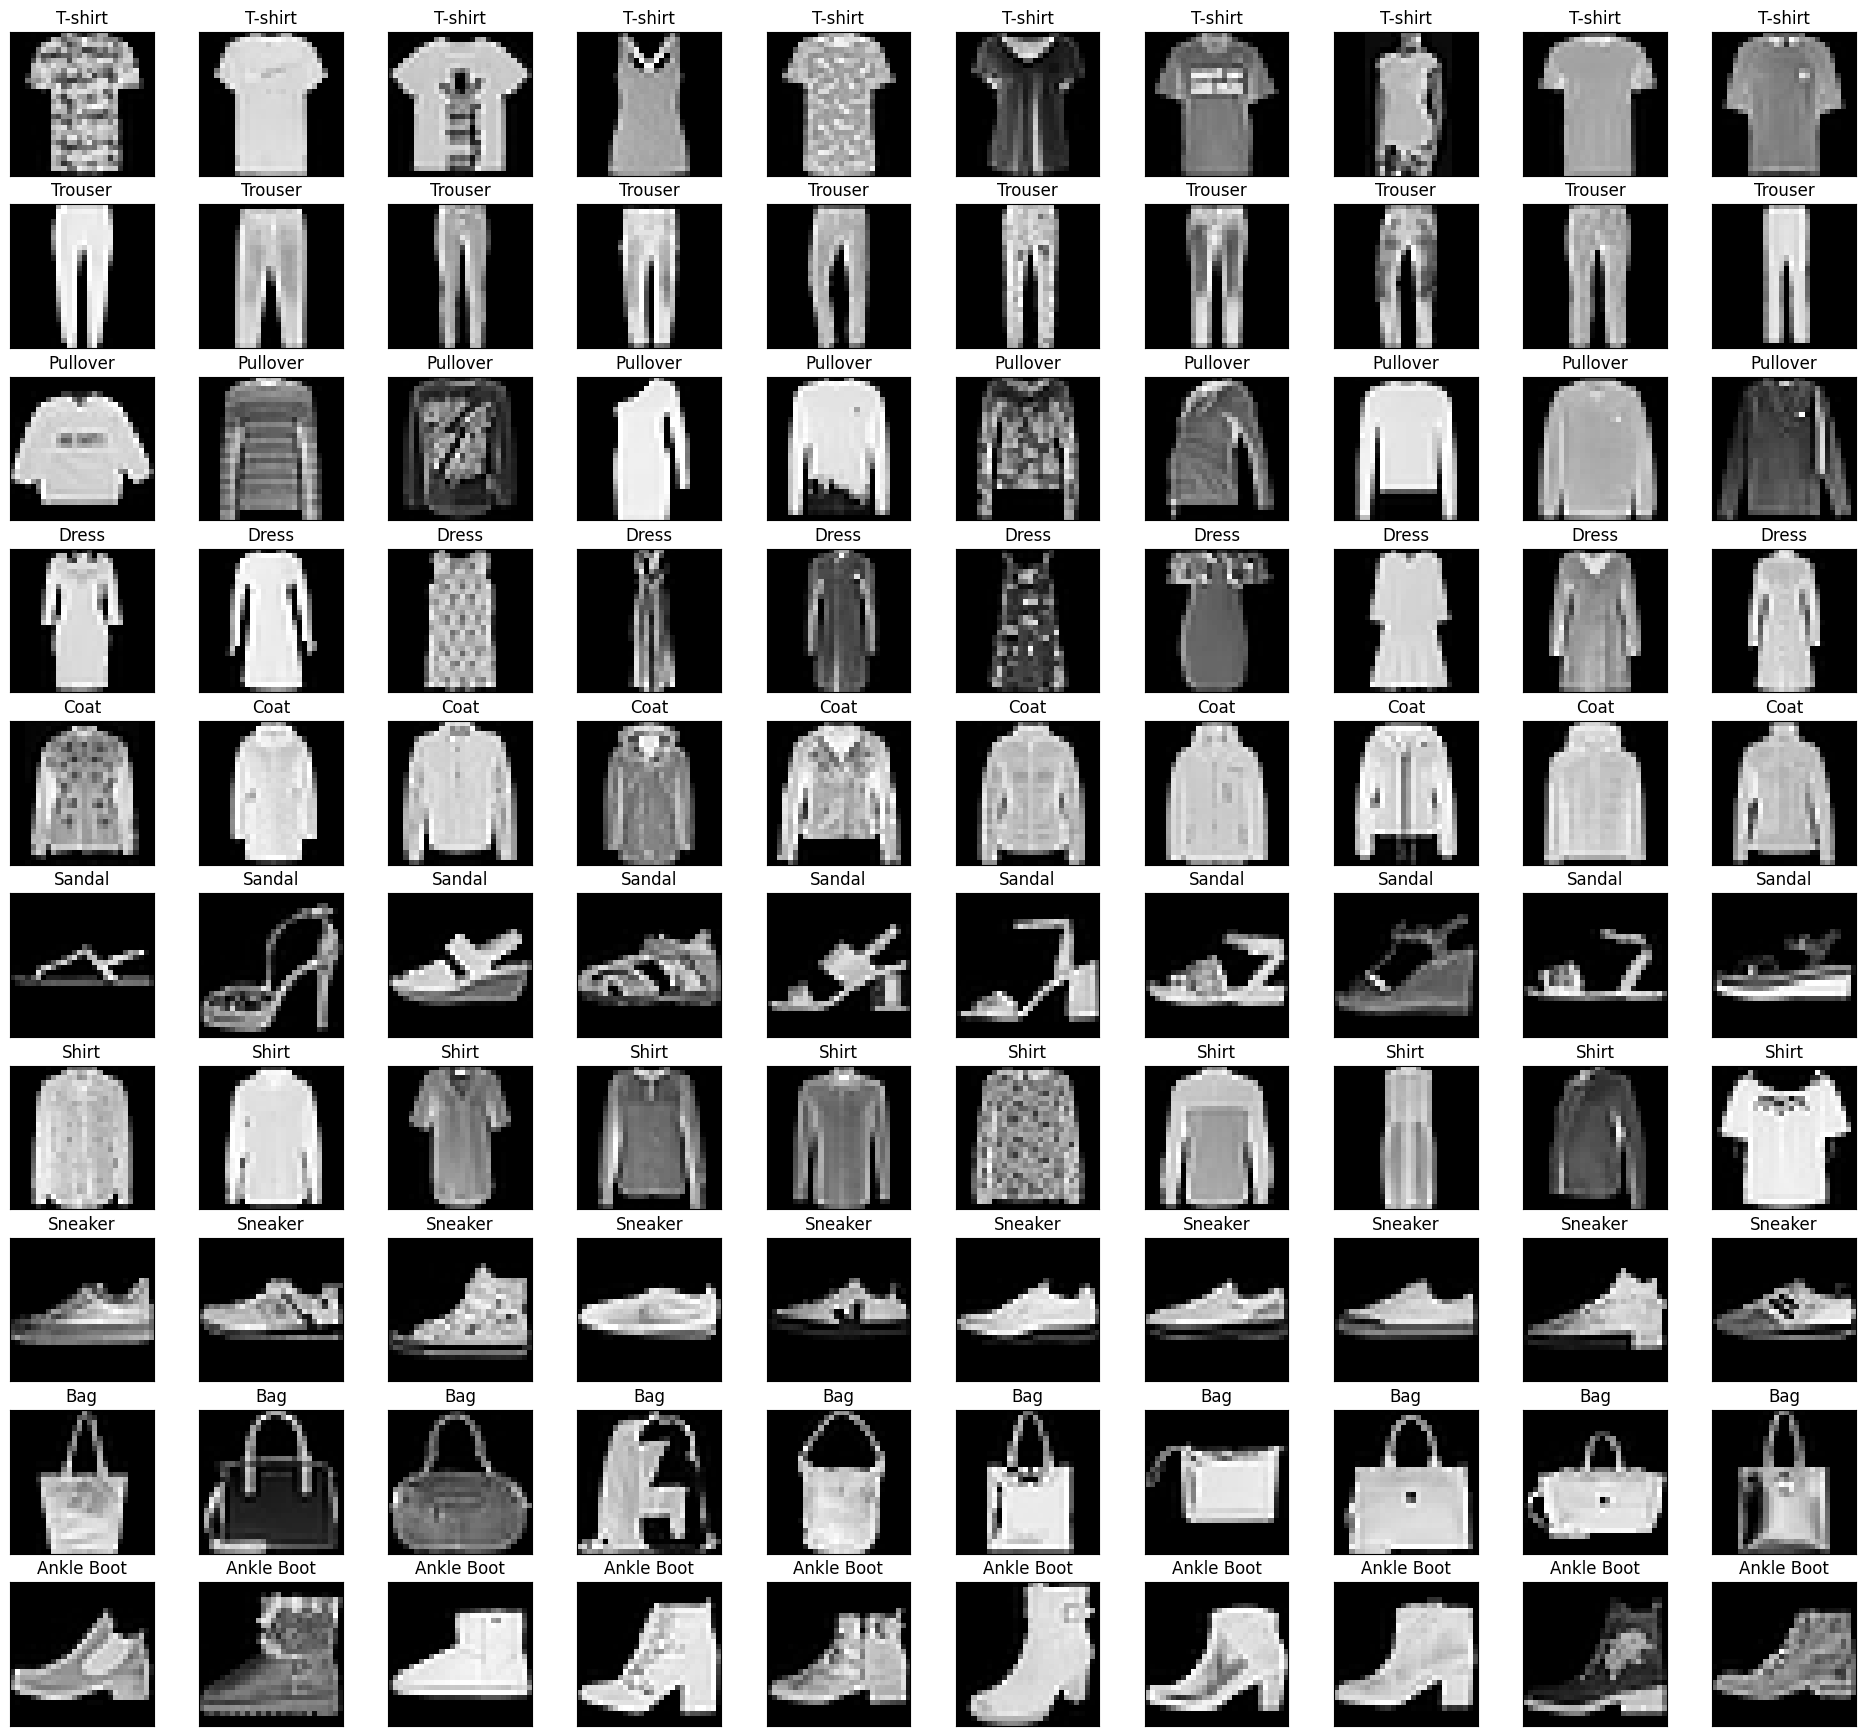

In [5]:
## 5 images of each variety per row
fig,axes = plt.subplots(nrows=10, ncols=10, figsize=(24,22))
axes = axes.ravel()
counter = -1

for k in range(10):
    df = train.loc[train.label==k].values
    for img_index in range(10):
        counter += 1
        axes[counter].imshow(
            df[img_index, 1:].reshape(28,28), 
            cmap="gray"
        )
        axes[counter].set_title(LABEL_MAP[k])
        axes[counter].set_xticks([])
        axes[counter].set_xticklabels([])
        axes[counter].set_yticks([])
        axes[counter].set_yticklabels([])
plt.show()

In [6]:
images = train.values[:, 1:].astype(np.float32)
min_max_scaler = lambda X: X/X.max()

images = min_max_scaler(images)

print(f"Train Images' Mean of Pixel Intensity: {images.mean():.5f}")
print(f"Train Images' Standard Deviation of Pixel Intensity: {images.std():.5f}")

Train Images' Mean of Pixel Intensity: 0.28610
Train Images' Standard Deviation of Pixel Intensity: 0.35281


# Dataset and DataLoader

In [7]:
class FashionDataset(Dataset):
    def __init__(self, 
                 data_path:str, 
                 is_train:bool,
                 img_transforms=None
                ):
        
        ### Default transformations if a transform structure is not provided
        if img_transforms is None:
            img_transforms = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.28610,), std=(0.35281,))
            ])
            
        data_array = pd.read_csv(data_path).values
        self.img_transforms = img_transforms
        self.y = None ## labels
        self.X = None ## images

        if is_train:
            self.y = data_array[:,0]
            self.X = data_array[:,1:].reshape(-1, 28, 28, 1).astype(np.uint8)
        else:
            self.X = data_array[:,1:].reshape(-1, 28, 28, 1).astype(np.uint8)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        if self.y is not None:
            return self.img_transforms(self.X[index]), self.y[index]
        return self.img_transforms(self.X[index])

In [8]:
train_path = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"
test_path  = "/kaggle/input/fashionmnist/fashion-mnist_test.csv"

### Create specialized datasets
nontest_dataset = FashionDataset(train_path, True)
test_dataset  = FashionDataset(test_path, False)

### Splits nontest_dataset to get train and validation sets
torch.manual_seed(SEED)  
train_size = int(0.8 * len(nontest_dataset))
val_size   = len(nontest_dataset) - train_size
train_subset, val_subset = random_split(nontest_dataset, [train_size, val_size])

### Create specialized dataloaders
train_loader = DataLoader(dataset=train_subset,
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(dataset=val_subset,
                          batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE, shuffle=False)

# Convolution Network

In [9]:
class DepSepConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DepSepConv2d, self).__init__()
        self.depconv = nn.Conv2d(in_channels, 
                                 in_channels,
                                 kernel_size=3,
                                 padding=1, 
                                 groups=in_channels)
        self.pointwise_conv = nn.Conv2d(in_channels,
                                        out_channels,
                                        kernel_size=1)
    def forward(self, x):
        out = self.depconv(x)
        out = self.pointwise_conv(out)
        return out

In [10]:
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        self.standardConv = nn.Sequential(
            # 1x28x28 -> 32x28x28
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.depSepConvs = nn.Sequential(
            # 32x28x28 -> 32x28x28
            DepSepConv2d(32, 32),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 32x28x28 -> 64x14x14
            DepSepConv2d(32, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=.25),
            nn.Linear(64*14*14, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=.5),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, 10)
        )
        self._initialize_weights()
        
    def _initialize_weights(self):
        torch.manual_seed(SEED)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None: 
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                
    def forward(self, x):
        out = self.standardConv(x)
        out = self.depSepConvs(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

# Training and Validation

In [11]:
def train(epoch):
    model.train()
    total_loss = 0.0 ## For logging average loss per epoch
    
    for batch_idx,(images, targets) in enumerate(train_loader):
        images, targets = images.to(DEVICE), targets.to(DEVICE)
        
        predictions = model(images)
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch_idx+1)%100 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, (batch_idx+1)*len(images), len(train_loader.dataset),
                100.*(batch_idx+1)/len(train_loader), loss.item())
                 )
    # Return the average loss for the epoch
    return total_loss/len(train_loader)

In [12]:
def evaluate(data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.inference_mode():
        for images, targets in data_loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            
            predictions = model(images)
            
            total_loss += F.cross_entropy(predictions, targets, reduction="sum").item()
            predictions = predictions.argmax(dim=1, keepdim=True)
            correct += predictions.eq(targets.view_as(predictions)).sum().item()
            
        avg_loss = total_loss/len(data_loader.dataset) 
        accuracy = 100.*correct/len(data_loader.dataset) 
        
        print("\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n".format(
            avg_loss, correct, len(data_loader.dataset), accuracy
             )
             )
        return avg_loss, accuracy

In [13]:
def predict(data_loader):
    model.eval()
    all_predictions = []

    with torch.inference_mode():
        for images in data_loader:
            images = images.to(DEVICE)
            predictions = model(images)
            predictions = predictions.argmax(dim=1, keepdim=True)
            all_predictions.append(predictions.cpu())
    
    test_pred = torch.cat(all_predictions, dim=0)
    return test_pred

In [14]:
n_epochs = 10

model = ConvNet1().to(DEVICE)
optimizer = optim.Adam(model.parameters(), 
                       lr=1e-3)
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

In [15]:
train_avg_losses = []
eval_avg_losses  = []
eval_accuracies  = []

for epoch in range(n_epochs):
    train_avg_loss = train(epoch)
    eval_avg_loss, eval_accuracy = evaluate(val_loader)
    
    train_avg_losses.append(train_avg_loss)
    eval_avg_losses.append(eval_avg_loss)
    eval_accuracies.append(eval_accuracy)

Train Epoch: 0 [6400/48000 (13%)]	Loss: 0.775747
Train Epoch: 0 [12800/48000 (27%)]	Loss: 0.367614
Train Epoch: 0 [19200/48000 (40%)]	Loss: 0.440931
Train Epoch: 0 [25600/48000 (53%)]	Loss: 0.328291
Train Epoch: 0 [32000/48000 (67%)]	Loss: 0.420237
Train Epoch: 0 [38400/48000 (80%)]	Loss: 0.260150
Train Epoch: 0 [44800/48000 (93%)]	Loss: 0.440224

Average loss: 0.2740, Accuracy: 10795/12000 (89.958%)

Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.292585
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.355602
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.336046
Train Epoch: 1 [25600/48000 (53%)]	Loss: 0.387629
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.171614
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.351968
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.299740

Average loss: 0.2651, Accuracy: 10802/12000 (90.017%)

Train Epoch: 2 [6400/48000 (13%)]	Loss: 0.190148
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.258727
Train Epoch: 2 [19200/48000 (40%)]	Loss: 0.186923
Train Epoch: 2 [25600/48000 (53%)]	Loss: 

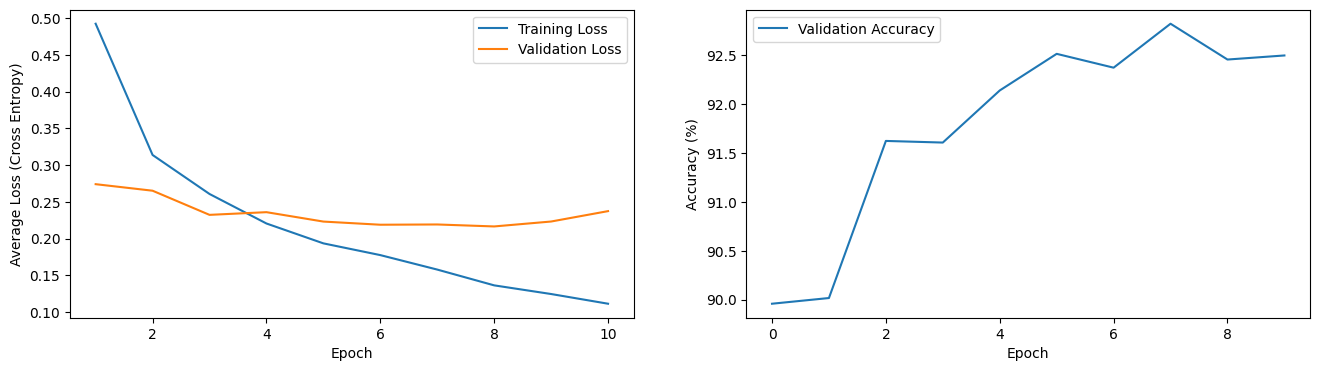

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,4))
sea.lineplot(x=np.arange(1,11), y=train_avg_losses, label="Training Loss", ax=axes[0])
sea.lineplot(x=np.arange(1,11), y=eval_avg_losses, label="Validation Loss", ax=axes[0])
sea.lineplot(x=np.arange(0,10), y=eval_accuracies, label="Validation Accuracy", ax=axes[1])

axes[0].set_xlabel("Epoch")
axes[1].set_xlabel("Epoch")

axes[0].set_ylabel("Average Loss (Cross Entropy)")
axes[1].set_ylabel("Accuracy (%)")

plt.show()

In [17]:
predictions = predict(test_loader)
predictions = predictions.to("cpu").numpy().reshape(-1)

quality = pd.DataFrame({"prediction":predictions,
                        "truth":test_labels})
quality["inaccuracy"] = quality.prediction!=quality.truth

quality

,prediction,truth,inaccuracy
0,0,0,False
1,1,1,False
2,2,2,False
3,6,2,True
4,3,3,False
...,...,...,...
9995,0,0,False
9996,6,6,False
9997,8,8,False
9998,8,8,False


In [18]:
inaccuracy_percentage = 100 * quality.inaccuracy.sum()/10000

print(f"Test Prediction Accuracy for Baseline Model: {100.-inaccuracy_percentage}%")

Test Prediction Accuracy for Baseline Model: 93.45%
